## Generate data

In [5]:
from codes import data as d
import numpy as np
from random import shuffle

In [6]:
# users and items will be described by 3 features
fake_data = d.FakeData(dimensions=3) 

# explanation for the first line: generate 100 users with preference centered at (5,-3,0)  
# plus noise sampled from zero mean normal distribution with standard deviation of 0.1
fake_data.add_user(preference=(5,-3,0), num=200, stdev=0.1) 
fake_data.add_user(preference=(0,5,-3), num=200, stdev=0.1)
fake_data.add_user(preference=(-3,0,5), num=200, stdev=0.1)
fake_data.add_user(preference=(1,1,1), num=200, stdev=0.1)
fake_data.add_item(feature=(5,0,0), num=100, stdev=0.1)
fake_data.add_item(feature=(0,5,0), num=100, stdev=0.1)
fake_data.add_item(feature=(0,0,5), num=100, stdev=0.1)

# rating of a user on a item is calculated as below:
# 1. get the dot product of all users and items
# 2.                  dot product < percentile 10 -> rating 1
#    percentile 10 <= dot product < percentile 30 -> rating 2
#    percentile 30 <= dot product < percentile 70 -> rating 3
#    percentile 70 <= dot product < percentile 90 -> rating 4
#    percentile 90 <= dot product                 -> rating 5
fake_data.generate_data(rating_percentile=(10,30,70,90), train=0.2) # 20% data used for training

In [7]:
# get data for training and shuffle it
user_index, item_index, ratings = fake_data.train
x = list(zip(user_index, item_index, ratings))
shuffle(x)

user_index, item_index, ratings = list(zip(*x))
user_index = np.array(user_index)
item_index = np.array(item_index)
ratings = np.array(ratings)

In [8]:
user_index = np.expand_dims(user_index, axis=1)
item_index = np.expand_dims(item_index, axis=1)
ratings = np.expand_dims(ratings, axis=1)

## Original embedding visualization

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [10]:
user_embed = TSNE(n_components=2).fit_transform(fake_data.users)
item_embed = TSNE(n_components=2).fit_transform(fake_data.items)

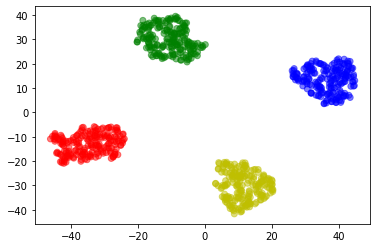

In [11]:
x, y = zip(*user_embed)
user_color = fake_data.get_color_list(user=True, color_list=['r','b','g','y'])
plt.scatter(x,y,c=user_color,alpha=0.5)

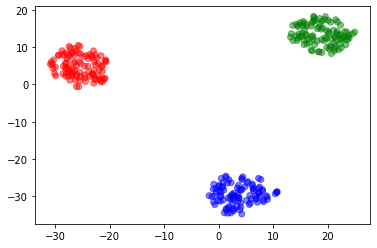

In [12]:
x, y = zip(*item_embed)
item_color = fake_data.get_color_list(user=False, color_list=['r','b','g'])
plt.scatter(x,y,c=item_color,alpha=0.5)

## Training

In [13]:
from codes import model as m
import keras
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [14]:
num_user = len(fake_data.users)
num_item = len(fake_data.items)
latent_dim = 3
model = m.get_model(num_user, num_item, latent_dim)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 3)         2400        input_1[0][0]                    
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 3)         900         input_2[0][0]                    
____________________________________________________________________________________________

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
#optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.99)
model.compile(optimizer=optimizer, loss='mse')

In [16]:
batch_size = 512
no_epochs = 100
validation_split = 0.2

checkpoint = ModelCheckpoint(
    "models/best_model.hdf5", monitor='val_loss', verbose=0, save_best_only=True, mode='auto', period=1
)

# start training
history = model.fit(
    [user_index,item_index], ratings, 
    epochs = no_epochs, batch_size = batch_size, verbose=0, 
    validation_split = validation_split, callbacks=[checkpoint]
)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


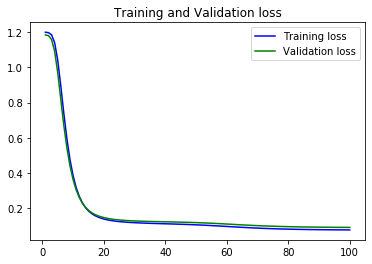

In [17]:
# visualization of training and validation loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Inference embedding visualization

In [49]:
from keras.models import load_model

In [18]:
#model_in_use = load_model('./models/best_model.hdf5')
model_in_use = model

In [19]:
user_embed = model_in_use.get_layer("user_embedding").get_weights()[0]
item_embed = model_in_use.get_layer("item_embedding").get_weights()[0]
user_embed = TSNE(n_components=2).fit_transform(user_embed)
item_embed = TSNE(n_components=2).fit_transform(item_embed)

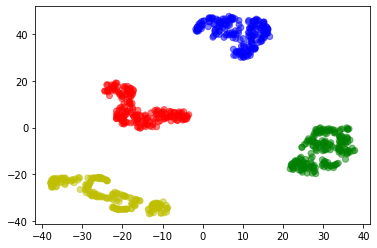

In [20]:
x, y = zip(*user_embed)
plt.scatter(x,y,c=user_color,alpha=0.5)

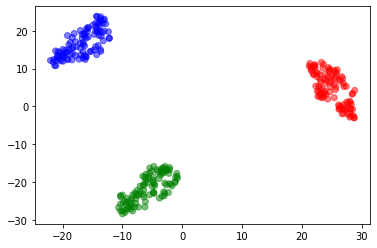

In [21]:
x, y = zip(*item_embed)
plt.scatter(x,y,c=item_color,alpha=0.5)

## Evaluation on test set

In [22]:
user_index_test, item_index_test, ratings_test = fake_data.test
user_index_test = np.expand_dims(user_index_test, axis=1)
item_index_test = np.expand_dims(item_index_test, axis=1)
ratings_test    = np.expand_dims(ratings_test, axis=1)

In [23]:
model_in_use.evaluate([user_index_test, item_index_test],ratings_test)

191728/191728 [==============================] - 10s 51us/step


0.08978872292739924